In [ ]:
!! pip install --upgrade transformers
!! pip install tf-keras
! pip install optuna

import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.3 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from transformers import TFBertForSequenceClassification, BertTokenizer, TFRobertaForSequenceClassification
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tqdm import tqdm
import warnings
!! pip install emoji
from TweetNormalizer import normalizeTweet
import optuna
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv("Features_For_Traditional_ML_Techniques.csv", index_col=0)
all_tweets = df['tweet']
texts_normalised = list(map(normalizeTweet, all_tweets))

In [ ]:
def prepare_dataset(texts, labels, tokenizer, shuffle, batch_size=32, max_length=64):
    # Convert texts to list if it's numpy array
    if isinstance(texts, np.ndarray):
        texts = texts.tolist()

    # Ensure labels are the right shape
    labels = np.array(labels)
    if len(labels.shape) == 1:
        labels = labels.reshape(-1, 1)

    encodings = tokenizer(
        texts,
        truncation=True,
        padding=True,
        return_tensors='tf',
        max_length=max_length,
        add_special_tokens=True
    )

    dataset = tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': encodings['input_ids'],
            'attention_mask': encodings['attention_mask']
        },
        labels
    ))
    dataset = dataset.cache()
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=50000)
    return dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    texts_normalised,
    df['majority_target'].astype(int),
    test_size=0.2,
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size = 0.2,
    random_state=42
)

# Initialize tokenizer
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")

config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.91M [00:00<?, ?B/s]

In [ ]:
 test_dataset = prepare_dataset(
        X_test,
        y_test,
        tokenizer,
        False,
        batch_size=64,
        max_length=128
    )

base

In [28]:
model = TFRobertaForSequenceClassification.from_pretrained("vinai/bertweet-base", num_labels = 1)
y_pred = model.predict(test_dataset)
logits = y_pred.logits
prob = tf.sigmoid(logits)
prob = prob.numpy()
y_pred_classes = (prob > 0.5).astype(int).flatten()
print(classification_report(y_test, y_pred_classes))
print(confusion_matrix(y_test, y_pred_classes))

tf_model.h5:   0%|          | 0.00/740M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


420/420 [==============================] - 211s 495ms/step
              precision    recall  f1-score   support

           0       0.45      0.44      0.45     13059
           1       0.49      0.50      0.49     13781

    accuracy                           0.47     26840
   macro avg       0.47      0.47      0.47     26840
weighted avg       0.47      0.47      0.47     26840

[[5721 7338]
 [6870 6911]]


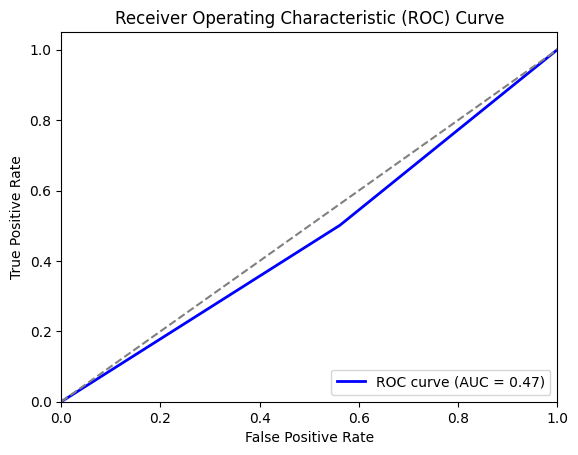

In [29]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_classes)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random chance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


bert-tweet-lr 5e-6, batch size 64, seq len 128

In [ ]:
model = TFRobertaForSequenceClassification.from_pretrained('/content/bert-tweet-1', num_labels = 1)
y_pred = model.predict(test_dataset)
logits = y_pred.logits
prob = tf.sigmoid(logits)
prob = prob.numpy()
y_pred_classes = (prob > 0.5).astype(int).flatten()
print(classification_report(y_test, y_pred_classes))
print(confusion_matrix(y_test, y_pred_classes))

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at /content/bert-tweet-1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


420/420 [==============================] - 225s 498ms/step
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     13059
           1       0.95      0.94      0.94     13781

    accuracy                           0.94     26840
   macro avg       0.94      0.94      0.94     26840
weighted avg       0.94      0.94      0.94     26840

[[12309   750]
 [  768 13013]]


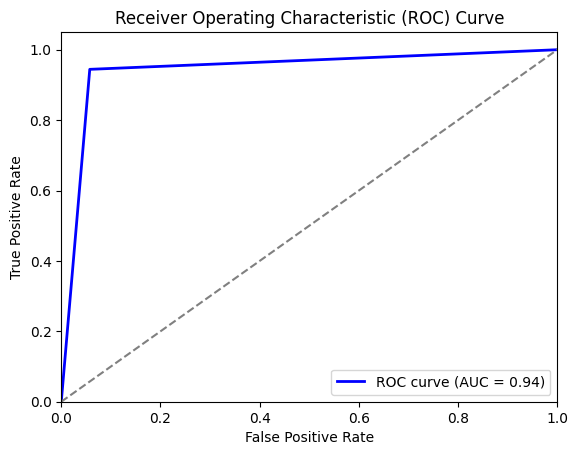

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_classes)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random chance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


bert-tweet-2e-5 batch size 64 seq len 128

In [ ]:
model = TFRobertaForSequenceClassification.from_pretrained('/content/bert-tweet-3', num_labels = 1)
y_pred = model.predict(test_dataset)
logits = y_pred.logits
prob = tf.sigmoid(logits)
prob = prob.numpy()
y_pred_classes = (prob > 0.5).astype(int).flatten()
print(classification_report(y_test, y_pred_classes))
print(confusion_matrix(y_test, y_pred_classes))

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at /content/bert-tweet-3.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


420/420 [==============================] - 222s 508ms/step
              precision    recall  f1-score   support

           0       0.95      0.94      0.94     13059
           1       0.94      0.95      0.95     13781

    accuracy                           0.95     26840
   macro avg       0.95      0.95      0.95     26840
weighted avg       0.95      0.95      0.95     26840

[[12293   766]
 [  697 13084]]


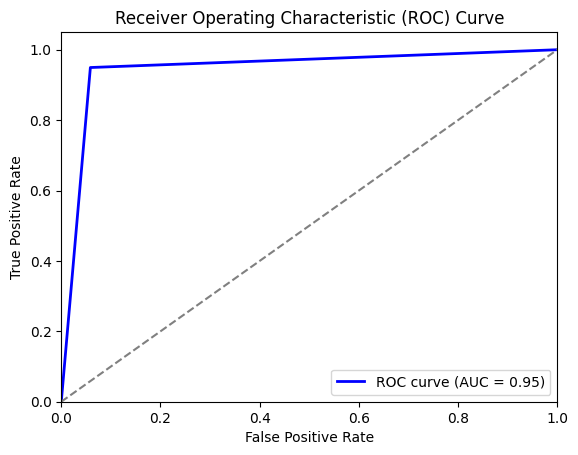

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_classes)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random chance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


bert-tweet-2e-5-batch size 64-seq len 256

In [ ]:
model = TFRobertaForSequenceClassification.from_pretrained('/content/bert-tweet-4', num_labels = 1)
y_pred = model.predict(test_dataset)
logits = y_pred.logits
prob = tf.sigmoid(logits)
prob = prob.numpy()
y_pred_classes = (prob > 0.5).astype(int).flatten()
print(classification_report(y_test, y_pred_classes))
print(confusion_matrix(y_test, y_pred_classes))

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at /content/bert-tweet-4.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


420/420 [==============================] - 216s 505ms/step
              precision    recall  f1-score   support

           0       0.95      0.94      0.94     13059
           1       0.94      0.95      0.95     13781

    accuracy                           0.95     26840
   macro avg       0.95      0.94      0.94     26840
weighted avg       0.95      0.95      0.94     26840

[[12249   810]
 [  666 13115]]


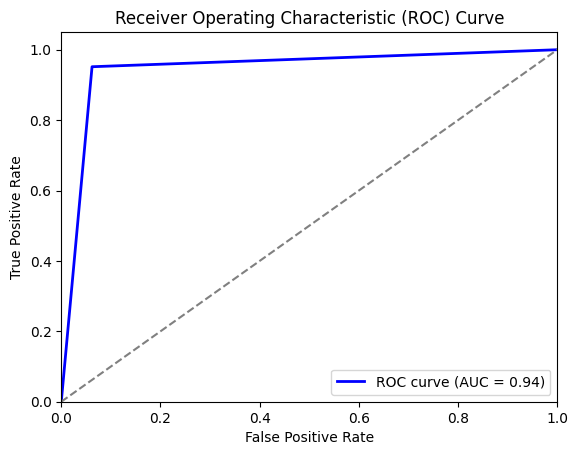

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_classes)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random chance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
